### Cloning [**simplif-ai**](https://github.com/namanshrimali/simplif-ai.git)
A library which have all the boilerplate codes available as a module, a one stop solution to jump start deep learning 

In [1]:
!git clone https://github.com/namanshrimali/simplif-ai.git
!pip install -U albumentations
%cd simplif-ai

%matplotlib inline 
# This turns on inline plotting, where plot graphics will appear in notebook.

fatal: destination path 'simplif-ai' already exists and is not an empty directory.
Requirement already up-to-date: albumentations in c:\users\naman\miniconda3\envs\aipy\lib\site-packages (0.5.2)
c:\Users\naman\Desktop\TSAI_EVA\simplif-ai


The output of torchvision datasets are PILImage images of range [0, 1].
We transform them to Tensors of normalized range [-1, 1].



In [2]:
from util.devices import find_device
from data_action.data_loader import *
from util.mean_std_calc import calc_mean_std


device = find_device()
BATCH_SIZE = 100
DATASET = 'CIFAR10' 
mean, std = (0.49139884, 0.48215783, 0.44653153), (0.20230089, 0.19941294, 0.200962)
# mean, std = calc_mean_std(DATASET) # calculates mean and standard deviation of the dataset

data_loader = Data_Loader(device, BATCH_SIZE, dataset = DATASET, mean = mean, std = std, transform_type='mmda')

trainloader = data_loader.load_training_data()
testloader = data_loader.load_testing_data()

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

target_layers = ["layer1", "layer2", "layer3", "layer4"] # for gradcam


device: cuda

Loading training data. Dataset: CIFAR10
Files already downloaded and verified
Training data loaded

Loading testing data.
Files already downloaded and verified
Test data loaded



Let us show some of the training images, for fun.



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

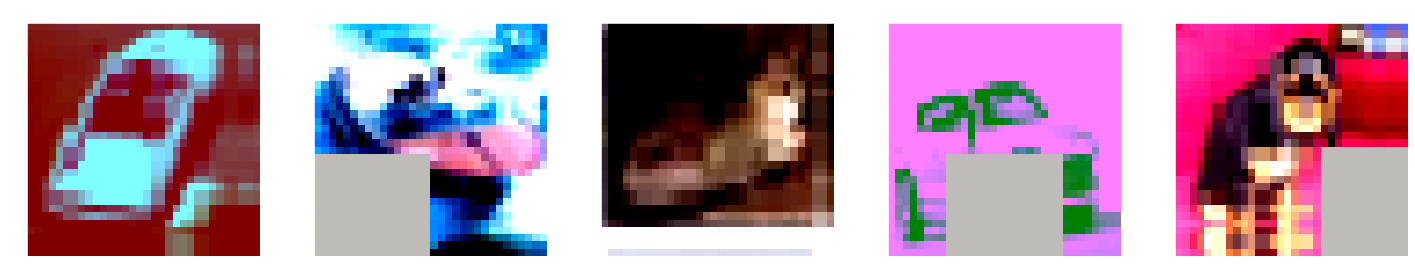

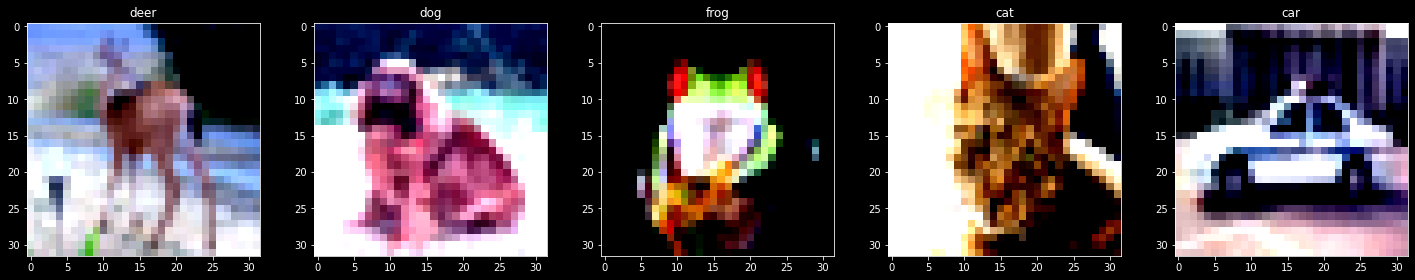

In [3]:
from util.image_plot import plot_images

# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images and their labels
plot_images(dataiter, classes, total=5)

# get some random testing images
dataiter = iter(testloader)
images, labels = dataiter.next()

# show images and their labels
plot_images(dataiter, classes, total=5)


2. Define a Convolution Neural Network
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Copy the neural network from the Neural Networks section before and modify it to
take 3-channel images (instead of 1-channel images as it was defined).



In [4]:
from model.resnet import ResNet18


model = ResNet18(0.1).to(device) # configuring 10% dropout in the resnet-18

### Model summary

In [5]:
!pip install torchsummary
from torchsummary import summary

summary(model, input_size=(3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
            Conv2d-3           [-1, 64, 32, 32]          36,864
       BatchNorm2d-4           [-1, 64, 32, 32]             128
           Dropout-5           [-1, 64, 32, 32]               0
            Conv2d-6           [-1, 64, 32, 32]          36,864
       BatchNorm2d-7           [-1, 64, 32, 32]             128
           Dropout-8           [-1, 64, 32, 32]               0
        BasicBlock-9           [-1, 64, 32, 32]               0
           Conv2d-10           [-1, 64, 32, 32]          36,864
      BatchNorm2d-11           [-1, 64, 32, 32]             128
          Dropout-12           [-1, 64, 32, 32]               0
           Conv2d-13           [-1, 64, 32, 32]          36,864
      BatchNorm2d-14           [-1, 64,

## Training model
> * finding optimal learning rate
> * defining Stochastic Gradient Descent as optimizer
> * defining scheduler as ReduceLROnPlateau, with patience of 4
---





### Defining optimizer and scheduler

In [6]:
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
import torch.nn as nn


optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=4, threshold=0.0001, threshold_mode='rel', cooldown=0, min_lr=0, eps=1e-08, verbose=True)
criterion = nn.CrossEntropyLoss()

### Finding optimal learning rate

100%|██████████| 100/100 [00:30<00:00,  3.31it/s]
Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 4.10E-01


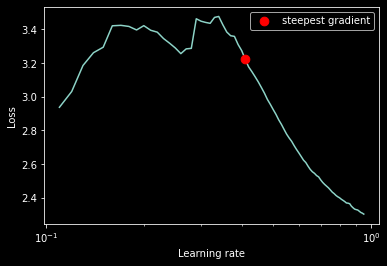

In [7]:
from analytics.lr_finder.finder_util import find_me_ideal_lr

ideal_lr = find_me_ideal_lr(model, optimizer, criterion, trainloader, device, plot_graph = True, num_iter = 100, step_mode = "linear")


### Setting optimal learning rate


In [8]:
for param_group in optimizer.param_groups:
    param_group['lr'] = ideal_lr

In [9]:

from learning.train import train
from learning.validate import test

train_loss = [] 
train_accuracy = []
test_loss = []
test_accuracy = []



for epoch in range(50):  # loop over the dataset multiple times
    misclassified = []
    print(f'Epoch: {epoch+1}')
    train(model, device, trainloader, train_loss, train_accuracy, optimizer)
    val_loss = test(model, device, testloader, test_loss, test_accuracy, misclassified)
    scheduler.step(val_loss)



loss=2.2171287536621094 batch_id=1999: 100%|██████████| 2000/2000 [03:18<00:00, 10.10it/s]
\Train set: Accuracy: 6539/50000 (13.0780%)


Test set: Average loss: 2.0654, Accuracy: 2108/10000 (21.08%)



In [10]:
from util.graph_plot import plot_me
plot_me(train_loss, train_accuracy, test_loss, test_accuracy)


## Data Analytics and Visualization of model performance

### Accuracy and Classwise performance of the model

In [11]:
from util.classwise_performance import clswse_perf

clswse_perf(model, testloader, device, BATCH_SIZE, classes)

### Misclassified Images
> Total of 25 misclassified images that the model in the last iteration failed to predict

---

In [12]:
# # plotting misclassified images 
# dataiter = iter(misclassified)

# # print images
# plot_images(dataiter, classes, total=25)

### GradCam report

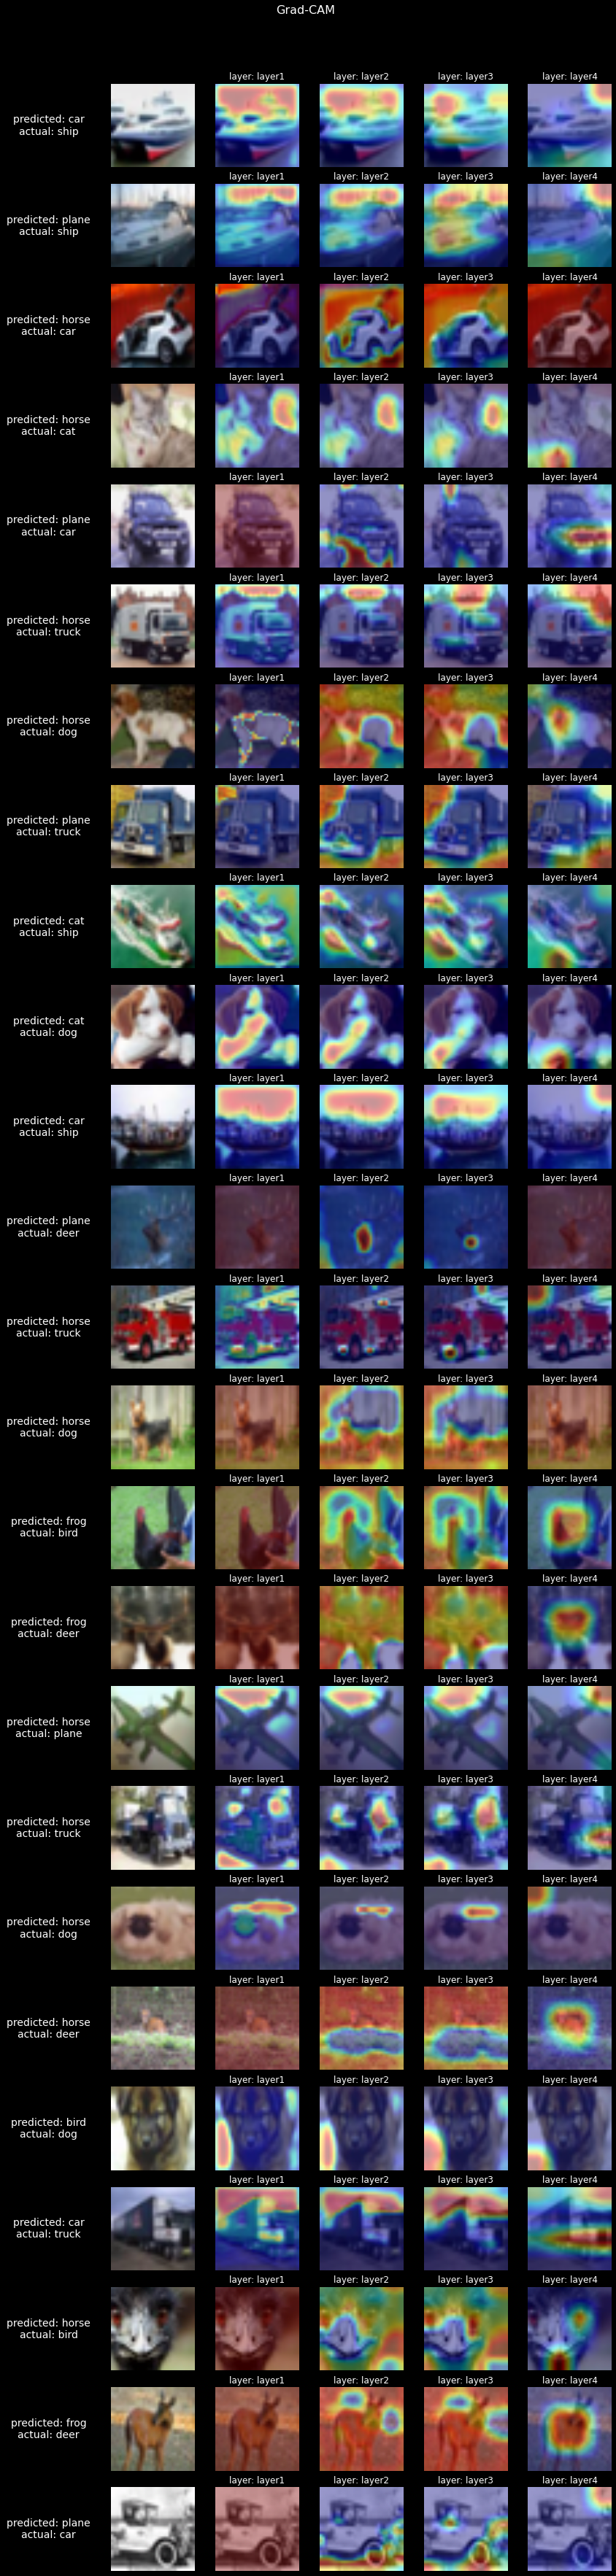

<Figure size 432x288 with 0 Axes>

In [13]:
from analytics.gradcam.report_gen import get_misclassified_gradcam
get_misclassified_gradcam(model, misclassified, device, target_layers, mean, std, classes, total=25)

In [14]:
# torch.save(net.state_dict(), 'resnet_cifar_89.30')